# Module 7: Understanding Communication Costs in Spark

**DSC 232R - Big Data Analysis Using Spark**

This notebook covers:
1. What shuffles are and why they're expensive
2. Operations that cause shuffles
3. Identifying shuffles in the Spark UI
4. Strategies to minimize shuffle costs
5. Partition strategy for optimal performance

## Key Takeaways

- **Shuffles** are the most expensive operations in Spark
- **Data movement** across executors dominates distributed computing costs
- **Minimizing shuffles** is often more impactful than adding resources
- **Broadcast joins** can eliminate shuffles for small tables

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, sum as spark_sum, broadcast
import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# Create SparkSession for local experimentation
spark = SparkSession.builder \
    .appName("Communication-Costs-Lab") \
    .master("local[4]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

print(f"Spark UI available at: {spark.sparkContext.uiWebUrl}")
print(f"Shuffle partitions: {spark.conf.get('spark.sql.shuffle.partitions')}")

Spark UI available at: http://b837eeee5ec4:4040
Shuffle partitions: 8


---

## 1. What is a Shuffle?

A **shuffle** occurs when Spark needs to redistribute data across executors. This happens when the output of one stage requires data from multiple input partitions.

### Shuffle Anatomy

```
BEFORE SHUFFLE (Data distributed by input partitions)
┌─────────────┐  ┌─────────────┐  ┌─────────────┐
│ Executor 1  │  │ Executor 2  │  │ Executor 3  │
│ Partition 1 │  │ Partition 2 │  │ Partition 3 │
│ key: A,B,C  │  │ key: A,B,D  │  │ key: B,C,D  │
└─────────────┘  └─────────────┘  └─────────────┘
       │               │               │
       └───────────────┼───────────────┘
                       │
              ┌────────┴────────┐
              │     SHUFFLE     │
              │  (Network I/O)  │
              │  (Disk I/O)     │
              └────────┬────────┘
                       │
       ┌───────────────┼───────────────┐
       │               │               │
       ▼               ▼               ▼
┌─────────────┐  ┌─────────────┐  ┌─────────────┐
│ Executor 1  │  │ Executor 2  │  │ Executor 3  │
│ All key: A  │  │ All key: B  │  │ All key:C,D │
└─────────────┘  └─────────────┘  └─────────────┘

AFTER SHUFFLE (Data distributed by key)
```

### The Cost of Shuffles

1. **Disk I/O**: Write intermediate data to local disk
2. **Network I/O**: Transfer data between executors
3. **Disk I/O again**: Read shuffled data from remote locations
4. **Serialization**: Convert objects to bytes and back
5. **Memory pressure**: Buffer data during transfer

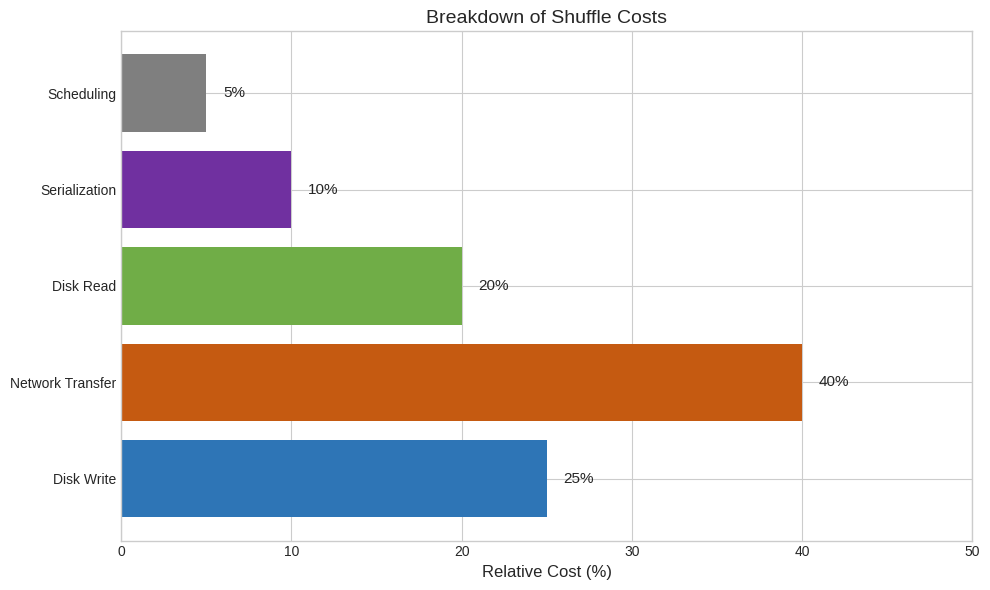

Key insight: Network transfer is typically the largest cost!


In [3]:
# Visualize shuffle costs
shuffle_components = {
    'Disk Write': 25,
    'Network Transfer': 40,
    'Disk Read': 20,
    'Serialization': 10,
    'Scheduling': 5
}

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2E75B6', '#C55A11', '#70AD47', '#7030A0', '#7F7F7F']

bars = ax.barh(list(shuffle_components.keys()), list(shuffle_components.values()),
               color=colors)
ax.set_xlabel('Relative Cost (%)', fontsize=12)
ax.set_title('Breakdown of Shuffle Costs', fontsize=14)

# Add value labels
for bar, val in zip(bars, shuffle_components.values()):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f'{val}%', va='center', fontsize=11)

ax.set_xlim(0, 50)
plt.tight_layout()
plt.show()

print("Key insight: Network transfer is typically the largest cost!")

---

## 2. Operations That Cause Shuffles

### Operations That Always Shuffle

| Operation | Why It Shuffles | Example |
|-----------|-----------------|--------|
| `groupBy()` | All rows with same key must be on same executor | `df.groupBy("category").count()` |
| `reduceByKey()` | Aggregation requires co-located keys | `rdd.reduceByKey(lambda a,b: a+b)` |
| `join()` | Matching keys must be co-located | `df1.join(df2, "key")` |
| `distinct()` | Must check all partitions for duplicates | `df.select("category").distinct()` |
| `repartition(n)` | Explicitly redistributes data | `df.repartition(100)` |
| `orderBy()` / `sort()` | Global ordering requires data exchange | `df.orderBy("timestamp")` |

In [4]:
# Create sample data to demonstrate shuffles
data = [(i, f"category_{i % 10}", np.random.random() * 100, i % 100)
        for i in range(100000)]

df = spark.createDataFrame(data, ["id", "category", "value", "group_id"])
df.cache()  # Cache to avoid re-reading
df.count()  # Materialize cache

print(f"DataFrame created with {df.count()} rows")
print(f"Partitions: {df.rdd.getNumPartitions()}")

DataFrame created with 100000 rows
Partitions: 4


In [5]:
# Demonstrate: Operations that cause shuffles
print("Operations That Cause Shuffles")
print("=" * 50)

# 1. GroupBy - SHUFFLES
print("\n1. groupBy() - Causes shuffle")
df.groupBy("category").count().explain()

# 2. Distinct - SHUFFLES
print("\n2. distinct() - Causes shuffle")
df.select("category").distinct().explain()

Operations That Cause Shuffles

1. groupBy() - Causes shuffle
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[category#1], functions=[count(1)])
   +- Exchange hashpartitioning(category#1, 8), ENSURE_REQUIREMENTS, [plan_id=112]
      +- HashAggregate(keys=[category#1], functions=[partial_count(1)])
         +- InMemoryTableScan [category#1]
               +- InMemoryRelation [id#0L, category#1, value#2, group_id#3L], StorageLevel(disk, memory, deserialized, 1 replicas)
                     +- *(1) Scan ExistingRDD[id#0L,category#1,value#2,group_id#3L]



2. distinct() - Causes shuffle
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[category#1], functions=[])
   +- Exchange hashpartitioning(category#1, 8), ENSURE_REQUIREMENTS, [plan_id=125]
      +- HashAggregate(keys=[category#1], functions=[])
         +- InMemoryTableScan [category#1]
               +- InMemoryRelation [id#0L, category#1, value#2, group_id#3L], StorageLeve

In [6]:
# Demonstrate: Operations that DON'T cause shuffles
print("Operations That Do NOT Cause Shuffles")
print("=" * 50)

# 1. Map/Filter operations - NO SHUFFLE
print("\n1. filter() - No shuffle")
df.filter(col("value") > 50).explain()

# 2. Select/WithColumn - NO SHUFFLE
print("\n2. select() - No shuffle")
df.select("id", "value").explain()

Operations That Do NOT Cause Shuffles

1. filter() - No shuffle
== Physical Plan ==
*(1) Filter (isnotnull(value#2) AND (value#2 > 50.0))
+- InMemoryTableScan [id#0L, category#1, value#2, group_id#3L], [isnotnull(value#2), (value#2 > 50.0)]
      +- InMemoryRelation [id#0L, category#1, value#2, group_id#3L], StorageLevel(disk, memory, deserialized, 1 replicas)
            +- *(1) Scan ExistingRDD[id#0L,category#1,value#2,group_id#3L]



2. select() - No shuffle
== Physical Plan ==
InMemoryTableScan [id#0L, value#2]
   +- InMemoryRelation [id#0L, category#1, value#2, group_id#3L], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(1) Scan ExistingRDD[id#0L,category#1,value#2,group_id#3L]




### Conditional Shuffle Operations

Not all operations always shuffle. Some can avoid shuffles depending on context:

| Operation | Shuffles When... | Avoids Shuffle When... |
|-----------|------------------|------------------------|
| `coalesce(n)` | n > current partitions | n ≤ current partitions |
| `join()` | Both tables are large | One table is broadcast |
| `union()` | Never shuffles | Always append-only |

---

## 3. Identifying Shuffles in Execution Plans

### Reading Spark's Explain Output

Key indicators of shuffles in the execution plan:
- `Exchange` - explicit shuffle operation
- `ShuffleQueryStage` - shuffle boundary
- `HashPartitioning` - data being partitioned by hash

In [7]:
# Complex query with multiple shuffles
print("Query with Multiple Shuffles")
print("=" * 50)

result = df.groupBy("category") \
           .agg(
               count("*").alias("count"),
               avg("value").alias("avg_value")
           ) \
           .orderBy("count", ascending=False)

# Extended explain shows more detail
result.explain(mode="extended")

Query with Multiple Shuffles
== Parsed Logical Plan ==
'Sort ['count DESC NULLS LAST], true
+- Aggregate [category#1], [category#1, count(1) AS count#568L, avg(value#2) AS avg_value#569]
   +- LogicalRDD [id#0L, category#1, value#2, group_id#3L], false

== Analyzed Logical Plan ==
category: string, count: bigint, avg_value: double
Sort [count#568L DESC NULLS LAST], true
+- Aggregate [category#1], [category#1, count(1) AS count#568L, avg(value#2) AS avg_value#569]
   +- LogicalRDD [id#0L, category#1, value#2, group_id#3L], false

== Optimized Logical Plan ==
Sort [count#568L DESC NULLS LAST], true
+- Aggregate [category#1], [category#1, count(1) AS count#568L, avg(value#2) AS avg_value#569]
   +- Project [category#1, value#2]
      +- InMemoryRelation [id#0L, category#1, value#2, group_id#3L], StorageLevel(disk, memory, deserialized, 1 replicas)
            +- *(1) Scan ExistingRDD[id#0L,category#1,value#2,group_id#3L]

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [co

In [8]:
# Count stages to count shuffles
def count_shuffles_in_plan(df):
    """Count the number of Exchange operations in a query plan."""
    plan = df._jdf.queryExecution().executedPlan().toString()
    exchange_count = plan.count("Exchange")
    return exchange_count

# Test with different queries
queries = [
    ("Simple filter", df.filter(col("value") > 50)),
    ("GroupBy", df.groupBy("category").count()),
    ("GroupBy + OrderBy", df.groupBy("category").count().orderBy("count")),
    ("Distinct", df.select("category").distinct()),
]

print("Shuffle Count by Query Type")
print("=" * 40)
for name, query in queries:
    shuffles = count_shuffles_in_plan(query)
    print(f"{name:25} : {shuffles} shuffle(s)")

Shuffle Count by Query Type
Simple filter             : 0 shuffle(s)
GroupBy                   : 1 shuffle(s)
GroupBy + OrderBy         : 2 shuffle(s)
Distinct                  : 1 shuffle(s)


---

## 3b. Data Skew Diagnosis and Salting Fix

**Data skew** occurs when some keys have far more rows than others, causing one executor to process a disproportionate share.

**Detect in Spark UI**: Stages → Summary Metrics → Duration row
- If **Max task duration > 3x Median**, you have data skew

**The fix**: **Salting** — break hot keys into sub-keys with a random suffix to distribute load evenly across executors.

In [9]:
# Create skewed data to demonstrate the problem
from pyspark.sql.functions import concat, lit, floor, rand, explode, array

# Skewed data: "hot_key" appears 50x more than other keys
skewed_data = []
for i in range(100000):
    if i < 50000:
        skewed_data.append((i, "hot_key", np.random.random() * 100))
    else:
        skewed_data.append((i, f"key_{i % 100}", np.random.random() * 100))

skewed_df = spark.createDataFrame(skewed_data, ["id", "join_key", "value"])

# Step 1: Diagnose skew - check key distribution
print("Key distribution (top 10):")
print("=" * 40)
skewed_df.groupBy("join_key").count() \
    .orderBy(col("count").desc()) \
    .show(10)

print("'hot_key' has ~50x more rows than other keys!")
print("This will cause one task to take much longer than others.")

Key distribution (top 10):
+--------+-----+
|join_key|count|
+--------+-----+
| hot_key|50000|
|   key_0|  500|
|  key_10|  500|
|  key_13|  500|
|  key_25|  500|
|  key_36|  500|
|  key_41|  500|
|  key_46|  500|
|  key_48|  500|
|  key_64|  500|
+--------+-----+
only showing top 10 rows
'hot_key' has ~50x more rows than other keys!
This will cause one task to take much longer than others.


In [10]:
# Step 2: Apply salting to fix skew
num_salts = 10  # Split hot keys into 10 buckets

# Salt the skewed DataFrame
salted_df = skewed_df.withColumn(
    "salted_key",
    concat(col("join_key"), lit("_"), floor(rand() * num_salts).cast("int"))
)

# Verify: hot_key is now split into hot_key_0 through hot_key_9
print("After salting - key distribution (top 15):")
print("=" * 50)
salted_df.groupBy("salted_key").count() \
    .orderBy(col("count").desc()) \
    .show(15)

print("'hot_key' is now split into 10 sub-keys, each ~5,000 rows")
print("Much more balanced across executors!")

After salting - key distribution (top 15):
+----------+-----+
|salted_key|count|
+----------+-----+
| hot_key_7| 5123|
| hot_key_6| 5046|
| hot_key_9| 5019|
| hot_key_4| 5007|
| hot_key_5| 4999|
| hot_key_0| 4999|
| hot_key_3| 4954|
| hot_key_8| 4954|
| hot_key_1| 4950|
| hot_key_2| 4949|
|  key_93_1|   73|
|  key_38_1|   69|
|   key_2_0|   68|
|  key_19_7|   68|
|  key_41_7|   67|
+----------+-----+
only showing top 15 rows
'hot_key' is now split into 10 sub-keys, each ~5,000 rows
Much more balanced across executors!


---

## 4. Strategies to Minimize Shuffle Costs

### Strategy 1: Use Broadcast Joins

When one table is small enough to fit in memory, broadcast it to avoid shuffling the large table.

### Join Strategy Analysis with explain()

Spark automatically selects a join strategy. Use `.explain()` to see which one was chosen:

| Strategy | When Used | Shuffle? |
|----------|-----------|----------|
| **BroadcastHashJoin** | One side < 10MB (default) | No |
| **SortMergeJoin** | Both sides large | Yes (both sides) |
| **ShuffledHashJoin** | One side much smaller but > broadcast threshold | Yes (both sides) |

Look for `Exchange` nodes in the plan — each one is a shuffle.

In [11]:
# Create a large table and a small lookup table
large_data = [(i, f"value_{i}", i % 100) for i in range(100000)]
large_df = spark.createDataFrame(large_data, ["id", "data", "lookup_key"])

small_data = [(i, f"lookup_{i}") for i in range(100)]
small_df = spark.createDataFrame(small_data, ["lookup_key", "lookup_value"])

print(f"Large table: {large_df.count()} rows")
print(f"Small table: {small_df.count()} rows")

Large table: 100000 rows
Small table: 100 rows


In [12]:
# Compare join strategies using explain()

print("1. Auto-selected plan (BroadcastHashJoin for small table):")
print("=" * 60)
auto_plan = large_df.join(small_df, "lookup_key")
auto_plan.explain()

print("\n2. Force SortMergeJoin by disabling broadcast:")
print("=" * 60)
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)
forced_smj = large_df.join(small_df, "lookup_key")
forced_smj.explain()

# Restore default
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 10 * 1024 * 1024)

print("\nNotice:")
print("- BroadcastHashJoin: BroadcastExchange (small table only, no shuffle)")
print("- SortMergeJoin: Exchange hashpartitioning on BOTH sides (2 shuffles)")

1. Auto-selected plan (BroadcastHashJoin for small table):
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [lookup_key#933L, id#931L, data#932, lookup_value#935]
   +- SortMergeJoin [lookup_key#933L], [lookup_key#934L], Inner
      :- Sort [lookup_key#933L ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(lookup_key#933L, 8), ENSURE_REQUIREMENTS, [plan_id=401]
      :     +- Filter isnotnull(lookup_key#933L)
      :        +- Scan ExistingRDD[id#931L,data#932,lookup_key#933L]
      +- Sort [lookup_key#934L ASC NULLS FIRST], false, 0
         +- Exchange hashpartitioning(lookup_key#934L, 8), ENSURE_REQUIREMENTS, [plan_id=402]
            +- Filter isnotnull(lookup_key#934L)
               +- Scan ExistingRDD[lookup_key#934L,lookup_value#935]



2. Force SortMergeJoin by disabling broadcast:
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [lookup_key#933L, id#931L, data#932, lookup_value#935]
   +- SortMergeJoin [lookup_key#933L], [loo

In [13]:
# BAD: Regular join - both tables shuffle
print("Regular Join (Both Tables Shuffle)")
print("=" * 50)
regular_join = large_df.join(small_df, "lookup_key")
regular_join.explain()

Regular Join (Both Tables Shuffle)
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [lookup_key#933L, id#931L, data#932, lookup_value#935]
   +- SortMergeJoin [lookup_key#933L], [lookup_key#934L], Inner
      :- Sort [lookup_key#933L ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(lookup_key#933L, 8), ENSURE_REQUIREMENTS, [plan_id=463]
      :     +- Filter isnotnull(lookup_key#933L)
      :        +- Scan ExistingRDD[id#931L,data#932,lookup_key#933L]
      +- Sort [lookup_key#934L ASC NULLS FIRST], false, 0
         +- Exchange hashpartitioning(lookup_key#934L, 8), ENSURE_REQUIREMENTS, [plan_id=464]
            +- Filter isnotnull(lookup_key#934L)
               +- Scan ExistingRDD[lookup_key#934L,lookup_value#935]




In [14]:
# GOOD: Broadcast join - only small table moves
print("Broadcast Join (No Shuffle on Large Table)")
print("=" * 50)
broadcast_join = large_df.join(broadcast(small_df), "lookup_key")
broadcast_join.explain()

Broadcast Join (No Shuffle on Large Table)
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [lookup_key#933L, id#931L, data#932, lookup_value#935]
   +- BroadcastHashJoin [lookup_key#933L], [lookup_key#934L], Inner, BuildRight, false
      :- Filter isnotnull(lookup_key#933L)
      :  +- Scan ExistingRDD[id#931L,data#932,lookup_key#933L]
      +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, bigint, false]),false), [plan_id=493]
         +- Filter isnotnull(lookup_key#934L)
            +- Scan ExistingRDD[lookup_key#934L,lookup_value#935]




In [15]:
# Time comparison
def time_query(query, description):
    """Time a Spark query execution."""
    start = time.time()
    query.count()  # Force execution
    elapsed = time.time() - start
    print(f"{description}: {elapsed:.3f}s")
    return elapsed

print("Join Performance Comparison")
print("=" * 40)
t_regular = time_query(regular_join, "Regular join")
t_broadcast = time_query(broadcast_join, "Broadcast join")
print(f"\nBroadcast is {t_regular/t_broadcast:.1f}x faster")

Join Performance Comparison
Regular join: 3.676s
Broadcast join: 1.831s

Broadcast is 2.0x faster


### Strategy 2: Reduce Data Before Shuffle

Filter or aggregate data before operations that shuffle:

In [16]:
# BAD: Shuffle all data, then filter
print("Bad: GroupBy then Filter")
bad_query = df.groupBy("category") \
              .agg(spark_sum("value").alias("total")) \
              .filter(col("total") > 5000)
bad_query.explain()

print("\n" + "=" * 50)

# BETTER: Filter rows early when possible
print("\nBetter: Filter rows before GroupBy (when applicable)")
# Note: This filter is on individual rows, not the aggregation result
better_query = df.filter(col("value") > 10) \
                 .groupBy("category") \
                 .agg(spark_sum("value").alias("total"))
better_query.explain()

Bad: GroupBy then Filter
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Filter (isnotnull(total#965) AND (total#965 > 5000.0))
   +- HashAggregate(keys=[category#1], functions=[sum(value#2)])
      +- Exchange hashpartitioning(category#1, 8), ENSURE_REQUIREMENTS, [plan_id=841]
         +- HashAggregate(keys=[category#1], functions=[partial_sum(value#2)])
            +- InMemoryTableScan [category#1, value#2]
                  +- InMemoryRelation [id#0L, category#1, value#2, group_id#3L], StorageLevel(disk, memory, deserialized, 1 replicas)
                        +- *(1) Scan ExistingRDD[id#0L,category#1,value#2,group_id#3L]




Better: Filter rows before GroupBy (when applicable)
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[category#1], functions=[sum(value#2)])
   +- Exchange hashpartitioning(category#1, 8), ENSURE_REQUIREMENTS, [plan_id=857]
      +- HashAggregate(keys=[category#1], functions=[partial_sum(value#2)])
         +- Filter (i

### Strategy 3: Use Coalesce Instead of Repartition

`repartition(n)` always shuffles data, but `coalesce(n)` can reduce partitions without a full shuffle.

In [17]:
# Start with more partitions
df_many_parts = df.repartition(20)
print(f"Starting partitions: {df_many_parts.rdd.getNumPartitions()}")

# BAD: repartition to reduce
print("\nRepartition (causes full shuffle):")
df_many_parts.repartition(4).explain()

# GOOD: coalesce to reduce
print("\nCoalesce (no full shuffle):")
df_many_parts.coalesce(4).explain()

Starting partitions: 20

Repartition (causes full shuffle):
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Exchange RoundRobinPartitioning(4), REPARTITION_BY_NUM, [plan_id=886]
   +- InMemoryTableScan [id#0L, category#1, value#2, group_id#3L]
         +- InMemoryRelation [id#0L, category#1, value#2, group_id#3L], StorageLevel(disk, memory, deserialized, 1 replicas)
               +- *(1) Scan ExistingRDD[id#0L,category#1,value#2,group_id#3L]



Coalesce (no full shuffle):
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Coalesce 4
   +- Exchange RoundRobinPartitioning(20), REPARTITION_BY_NUM, [plan_id=897]
      +- InMemoryTableScan [id#0L, category#1, value#2, group_id#3L]
            +- InMemoryRelation [id#0L, category#1, value#2, group_id#3L], StorageLevel(disk, memory, deserialized, 1 replicas)
                  +- *(1) Scan ExistingRDD[id#0L,category#1,value#2,group_id#3L]




### Strategy 4: Partition by Key for Repeated Joins

If you join on the same key repeatedly, pre-partition both DataFrames by the join key:

```python
# Partition both DataFrames by join key
df1_partitioned = df1.repartition(100, "join_key")
df2_partitioned = df2.repartition(100, "join_key")

# Cache the partitioned versions
df1_partitioned.cache()
df2_partitioned.cache()

# Subsequent joins on "join_key" won't shuffle
result1 = df1_partitioned.join(df2_partitioned, "join_key")
```

The initial `repartition` shuffles once, but all subsequent joins on that key avoid shuffles entirely.

### Strategy 5: Avoid Unnecessary Sorts

Sorting is expensive - only do it when necessary for output:

In [18]:
# BAD: Sort before groupBy (sort will be lost!)
print("Unnecessary sort (wasted work):")
bad_sort = df.orderBy("id").groupBy("category").count()
bad_sort.explain()

print("\n" + "=" * 50)

# GOOD: Only sort when needed for output
print("\nSort only for output:")
good_sort = df.groupBy("category").count().orderBy("count", ascending=False)
good_sort.explain()

Unnecessary sort (wasted work):
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[category#1], functions=[count(1)])
   +- Exchange hashpartitioning(category#1, 8), ENSURE_REQUIREMENTS, [plan_id=911]
      +- HashAggregate(keys=[category#1], functions=[partial_count(1)])
         +- InMemoryTableScan [category#1]
               +- InMemoryRelation [id#0L, category#1, value#2, group_id#3L], StorageLevel(disk, memory, deserialized, 1 replicas)
                     +- *(1) Scan ExistingRDD[id#0L,category#1,value#2,group_id#3L]




Sort only for output:
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [count#1389L DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(count#1389L DESC NULLS LAST, 8), ENSURE_REQUIREMENTS, [plan_id=931]
      +- HashAggregate(keys=[category#1], functions=[count(1)])
         +- Exchange hashpartitioning(category#1, 8), ENSURE_REQUIREMENTS, [plan_id=928]
            +- HashAggregate(keys=[category#1], functions=

### AQE Deep Dive

AQE (Adaptive Query Execution) optimizes queries at **runtime** based on actual data statistics. Three capabilities:

1. **Auto-coalesce** small partitions after shuffle → fewer, larger partitions
2. **Auto-optimize skew joins** → splits oversized partitions automatically (automatic salting!)
3. **Runtime join switching** → SortMergeJoin → BroadcastHashJoin if data turns out small

**When AQE helps**: small post-shuffle partitions, skewed joins, filters that reduce data dramatically

**When AQE doesn't help**: skewed `groupBy` (only handles join skew), data too large for broadcast

In [19]:
# AQE configuration for your projects

print("Recommended AQE Configuration")
print("=" * 50)

aqe_configs = {
    "spark.sql.adaptive.enabled": ("True", "Master switch for AQE"),
    "spark.sql.adaptive.coalescePartitions.enabled": ("True", "Merge small post-shuffle partitions"),
    "spark.sql.adaptive.skewJoin.enabled": ("True", "Auto-split skewed join partitions"),
    "spark.sql.adaptive.advisoryPartitionSizeInBytes": ("64MB", "Target size after coalescing"),
    "spark.sql.adaptive.skewJoin.skewedPartitionThresholdInBytes": ("256MB", "Partition size to trigger skew handling"),
    "spark.sql.adaptive.skewJoin.skewedPartitionFactor": ("5", "Skew if partition > factor x median"),
}

for config, (value, description) in aqe_configs.items():
    spark.conf.set(config, value)
    print(f"  {config}")
    print(f"    = {value}  ({description})")
    print()

# Verify AQE is active
print(f"AQE enabled: {spark.conf.get('spark.sql.adaptive.enabled')}")
print(f"Skew join:   {spark.conf.get('spark.sql.adaptive.skewJoin.enabled')}")
print(f"\nAQE will now optimize your queries at runtime automatically!")

Recommended AQE Configuration
  spark.sql.adaptive.enabled
    = True  (Master switch for AQE)

  spark.sql.adaptive.coalescePartitions.enabled
    = True  (Merge small post-shuffle partitions)

  spark.sql.adaptive.skewJoin.enabled
    = True  (Auto-split skewed join partitions)

  spark.sql.adaptive.advisoryPartitionSizeInBytes
    = 64MB  (Target size after coalescing)

  spark.sql.adaptive.skewJoin.skewedPartitionThresholdInBytes
    = 256MB  (Partition size to trigger skew handling)

  spark.sql.adaptive.skewJoin.skewedPartitionFactor
    = 5  (Skew if partition > factor x median)

AQE enabled: True
Skew join:   True

AQE will now optimize your queries at runtime automatically!


---

## 5. Partition Strategy

The number of partitions affects both parallelism and shuffle overhead.

In [20]:
def analyze_partition_impact(data_size, partition_counts):
    """
    Analyze the impact of partition count on performance.

    Trade-offs:
    - Too few: underutilized parallelism, memory pressure
    - Too many: scheduling overhead, small file problem
    """
    results = []

    for num_parts in partition_counts:
        # Estimated values (in a real scenario, measure these)
        data_per_partition_mb = data_size / num_parts
        scheduling_overhead_ms = num_parts * 2  # ~2ms per partition
        parallelism_utilization = min(1.0, num_parts / 8)  # Assume 8 cores

        results.append({
            'partitions': num_parts,
            'data_per_part_mb': data_per_partition_mb,
            'scheduling_overhead_ms': scheduling_overhead_ms,
            'parallelism_util': parallelism_utilization
        })

    return results

# Analyze for 1GB dataset
data_size_mb = 1024  # 1 GB
partition_options = [2, 4, 8, 16, 32, 64, 128, 256]

analysis = analyze_partition_impact(data_size_mb, partition_options)

print("Partition Analysis (1 GB dataset, 8 cores)")
print("=" * 65)
print(f"{'Partitions':>10} {'MB/Part':>10} {'Sched OH (ms)':>15} {'Parallelism':>12}")
print("-" * 65)

for a in analysis:
    print(f"{a['partitions']:>10} {a['data_per_part_mb']:>10.1f} "
          f"{a['scheduling_overhead_ms']:>15.0f} {a['parallelism_util']:>11.0%}")

Partition Analysis (1 GB dataset, 8 cores)
Partitions    MB/Part   Sched OH (ms)  Parallelism
-----------------------------------------------------------------
         2      512.0               4         25%
         4      256.0               8         50%
         8      128.0              16        100%
        16       64.0              32        100%
        32       32.0              64        100%
        64       16.0             128        100%
       128        8.0             256        100%
       256        4.0             512        100%


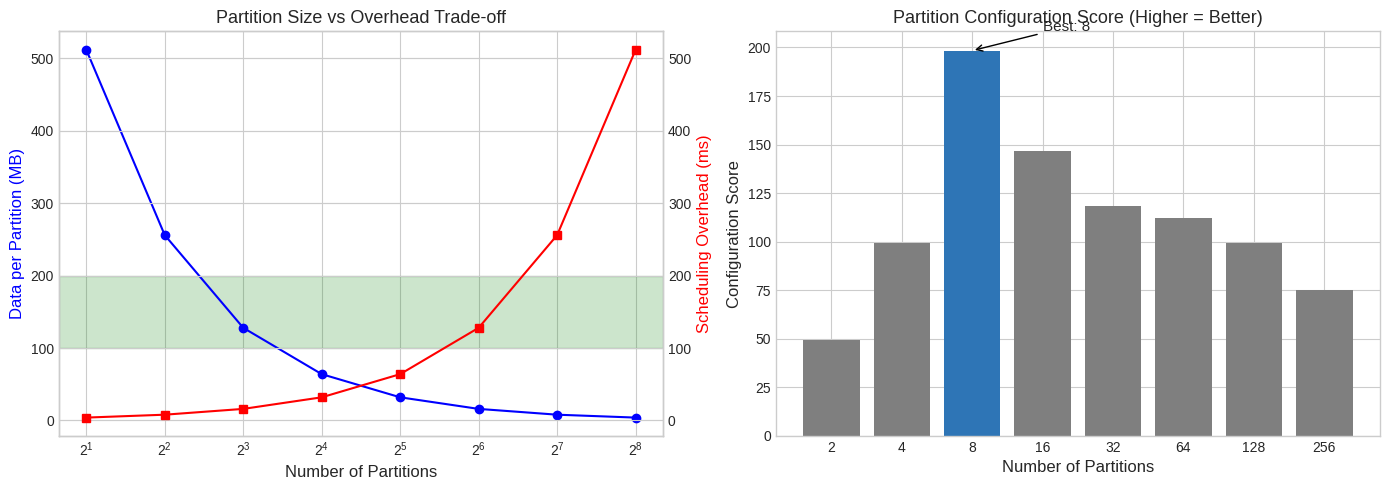

In [21]:
# Visualize partition trade-offs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

partitions = [a['partitions'] for a in analysis]
data_per_part = [a['data_per_part_mb'] for a in analysis]
scheduling = [a['scheduling_overhead_ms'] for a in analysis]
parallelism = [a['parallelism_util'] * 100 for a in analysis]

# Left: Data per partition and scheduling overhead
ax1 = axes[0]
ax1_twin = ax1.twinx()

line1 = ax1.plot(partitions, data_per_part, 'b-o', label='Data/Partition (MB)')
line2 = ax1_twin.plot(partitions, scheduling, 'r-s', label='Scheduling Overhead (ms)')

ax1.set_xlabel('Number of Partitions', fontsize=12)
ax1.set_ylabel('Data per Partition (MB)', color='blue', fontsize=12)
ax1_twin.set_ylabel('Scheduling Overhead (ms)', color='red', fontsize=12)
ax1.set_xscale('log', base=2)
ax1.set_title('Partition Size vs Overhead Trade-off', fontsize=13)

# Add optimal range annotation
ax1.axhspan(100, 200, alpha=0.2, color='green', label='Optimal range (100-200 MB)')

# Right: Sweet spot analysis
ax2 = axes[1]

# Calculate a "score" balancing all factors
# Higher is better: good parallelism, reasonable partition size, low overhead
scores = []
for a in analysis:
    size_score = 100 if 100 <= a['data_per_part_mb'] <= 200 else \
                 50 if 50 <= a['data_per_part_mb'] <= 500 else 25
    parallel_score = a['parallelism_util'] * 100
    overhead_penalty = min(50, a['scheduling_overhead_ms'] / 10)
    total_score = size_score + parallel_score - overhead_penalty
    scores.append(total_score)

colors = ['#2E75B6' if s == max(scores) else '#7F7F7F' for s in scores]
ax2.bar(range(len(partitions)), scores, color=colors)
ax2.set_xticks(range(len(partitions)))
ax2.set_xticklabels(partitions)
ax2.set_xlabel('Number of Partitions', fontsize=12)
ax2.set_ylabel('Configuration Score', fontsize=12)
ax2.set_title('Partition Configuration Score (Higher = Better)', fontsize=13)

# Mark best option
best_idx = scores.index(max(scores))
ax2.annotate(f'Best: {partitions[best_idx]}',
             xy=(best_idx, scores[best_idx]),
             xytext=(best_idx + 1, scores[best_idx] + 10),
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=11)

plt.tight_layout()
plt.show()

### Partition Rules of Thumb

```python
# Good starting point for shuffle partitions
num_partitions = num_executors * cores_per_executor * 2

# Or based on data size (target 100-200 MB per partition)
num_partitions = data_size_mb / 150
```

### Adaptive Query Execution (Spark 3.0+)

Let Spark automatically adjust partitions:

In [22]:
# Enable Adaptive Query Execution
spark.conf.set("spark.sql.adaptive.enabled", True)
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", True)

print("Adaptive Query Execution settings:")
print(f"  AQE enabled: {spark.conf.get('spark.sql.adaptive.enabled')}")
print(f"  Coalesce enabled: {spark.conf.get('spark.sql.adaptive.coalescePartitions.enabled')}")
print("\nAQE will automatically optimize partition counts during execution!")

Adaptive Query Execution settings:
  AQE enabled: true
  Coalesce enabled: true

AQE will automatically optimize partition counts during execution!


---

## 5b. Estimating Shuffle Cost

For planning purposes, you can estimate shuffle costs:

$$\text{Shuffle Cost} \approx \text{Data Size} \times \text{Shuffle Ratio} \times \text{Network Overhead}$$

Where:
- **Data Size**: Size of columns involved in the groupBy/join
- **Shuffle Ratio**: Typically 1.0-3.0 (data can expand with many groups)
- **Network Overhead**: ~1.5-2.0x for serialization and protocol

---

## 8. Spill Diagnosis and Fix

When Spark doesn't have enough memory for intermediate data during shuffles, it **spills** data to disk — a major performance killer.

### Finding Spill in Spark UI
Navigate to **Stages → Summary Metrics → Spill (Memory/Disk) columns**

| Spill Amount | Severity | Impact |
|-------------|----------|--------|
| 0 | None | Ideal |
| < 1 GB | Minor | Slight slowdown |
| 1-10 GB | Moderate | Noticeable degradation |
| > 10 GB | Severe | Major performance hit |

### Fixes (in priority order):
1. Increase `spark.sql.shuffle.partitions` (free — no more resources)
2. Increase `spark.executor.memory` (requires more SLURM allocation)
3. Increase `spark.memory.fraction` (0.6 → 0.8, trades cache for execution)
4. Apply salting (if caused by data skew)

In [23]:
# Spill fix configuration reference

print("Spill Fix Configuration Reference")
print("=" * 55)
print()

fixes = [
    ("Fix 1: More partitions (free!)", {
        "spark.sql.shuffle.partitions": "400  # Was 200; more partitions = less data per task"
    }),
    ("Fix 2: More executor memory", {
        "spark.executor.memory": "32g  # Was 16g; requires larger SLURM allocation"
    }),
    ("Fix 3: More memory for execution", {
        "spark.memory.fraction": "0.8  # Was 0.6; trades caching space for execution"
    }),
]

for title, configs in fixes:
    print(f"{title}:")
    for key, val in configs.items():
        print(f'  spark.conf.set("{key}", "{val.split("  #")[0].strip()}")')
        print(f'  # {val.split("# ")[1] if "# " in val else ""}')
    print()

print("Diagnostic workflow:")
print("  1. Run your job")
print("  2. Check Spark UI → Stages → Spill (Memory/Disk) columns")
print("  3. If Spill > 0, apply fixes in order above")
print("  4. Re-run and check if spill is eliminated")
print()
print("For hands-on spill diagnosis, see Module 08: Spark UI Debugging Lab")

Spill Fix Configuration Reference

Fix 1: More partitions (free!):
  spark.conf.set("spark.sql.shuffle.partitions", "400")
  # Was 200; more partitions = less data per task

Fix 2: More executor memory:
  spark.conf.set("spark.executor.memory", "32g")
  # Was 16g; requires larger SLURM allocation

Fix 3: More memory for execution:
  spark.conf.set("spark.memory.fraction", "0.8")
  # Was 0.6; trades caching space for execution

Diagnostic workflow:
  1. Run your job
  2. Check Spark UI → Stages → Spill (Memory/Disk) columns
  3. If Spill > 0, apply fixes in order above
  4. Re-run and check if spill is eliminated

For hands-on spill diagnosis, see Module 08: Spark UI Debugging Lab


In [24]:
# Estimate shuffle cost for a groupBy operation
data_size_gb = 50
columns_in_groupby = 3
total_columns = 20
shuffle_ratio = 1.5
network_overhead = 2.0

# Only columns used in groupBy + aggregation are shuffled
relevant_data = data_size_gb * (columns_in_groupby / total_columns)
estimated_shuffle = relevant_data * shuffle_ratio * network_overhead

print("Shuffle Cost Estimation Example")
print("=" * 50)
print(f"Total data size:       {data_size_gb} GB")
print(f"Relevant columns:      {columns_in_groupby}/{total_columns}")
print(f"Data actually shuffled: {relevant_data:.1f} GB")
print(f"Estimated shuffle:     {estimated_shuffle:.1f} GB")
print(f"\nWith 1 Gbps network: ~{estimated_shuffle * 8:.0f} seconds minimum transfer time")

Shuffle Cost Estimation Example
Total data size:       50 GB
Relevant columns:      3/20
Data actually shuffled: 7.5 GB
Estimated shuffle:     22.5 GB

With 1 Gbps network: ~180 seconds minimum transfer time


---

## 6. Exercise: Optimize a Query

### Exercise 1: Identify and Reduce Shuffles

Given this code, identify how many shuffles occur and optimize it:

In [25]:
# Setup: Create tables for the exercise
orders = spark.createDataFrame(
    [(i, i % 1000, i % 100, np.random.random() * 100)
     for i in range(100000)],
    ["order_id", "customer_id", "product_id", "amount"]
)

customers = spark.createDataFrame(
    [(i, f"Customer_{i}", f"Region_{i % 10}") for i in range(1000)],
    ["customer_id", "name", "region"]
)

products = spark.createDataFrame(
    [(i, f"Product_{i}", f"Category_{i % 5}") for i in range(100)],
    ["product_id", "product_name", "category"]
)

print(f"Orders: {orders.count()} rows")
print(f"Customers: {customers.count()} rows")
print(f"Products: {products.count()} rows")

Orders: 100000 rows
Customers: 1000 rows
Products: 100 rows


In [26]:
# Exercise: Original query - how many shuffles?
original_query = orders.join(customers, "customer_id") \
                       .join(products, "product_id") \
                       .groupBy("category") \
                       .agg(spark_sum("amount").alias("total")) \
                       .orderBy("total", ascending=False)

print("Original Query Plan:")
print("=" * 50)
original_query.explain()

# TODO:
# 1. Count the number of shuffles (Exchange operations)
# 2. Identify which operations cause shuffles
# 3. Write an optimized version below

Original Query Plan:
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [total#1489 DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(total#1489 DESC NULLS LAST, 8), ENSURE_REQUIREMENTS, [plan_id=1118]
      +- HashAggregate(keys=[category#1466], functions=[sum(amount#1460)])
         +- Exchange hashpartitioning(category#1466, 8), ENSURE_REQUIREMENTS, [plan_id=1115]
            +- HashAggregate(keys=[category#1466], functions=[partial_sum(amount#1460)])
               +- Project [amount#1460, category#1466]
                  +- SortMergeJoin [product_id#1459L], [product_id#1464L], Inner
                     :- Sort [product_id#1459L ASC NULLS FIRST], false, 0
                     :  +- Exchange hashpartitioning(product_id#1459L, 8), ENSURE_REQUIREMENTS, [plan_id=1107]
                     :     +- Project [product_id#1459L, amount#1460]
                     :        +- SortMergeJoin [customer_id#1458L], [customer_id#1461L], Inner
                     :           

In [27]:
# YOUR OPTIMIZED QUERY HERE

# Hints:
# - customers and products tables are small - can they be broadcast?
# - Is the orderBy at the end necessary for your use case?

optimized_query = None  # Replace with your optimized query

# optimized_query.explain()

In [28]:
# Solution
print("Optimized Query Plan:")
print("=" * 50)

optimized_query = orders.join(broadcast(customers), "customer_id") \
                        .join(broadcast(products), "product_id") \
                        .groupBy("category") \
                        .agg(spark_sum("amount").alias("total")) \
                        .orderBy("total", ascending=False)

optimized_query.explain()

# Compare execution times
print("\nPerformance Comparison:")
print("=" * 40)
t_orig = time_query(original_query, "Original")
t_opt = time_query(optimized_query, "Optimized")
print(f"\nImprovement: {(t_orig - t_opt) / t_orig:.0%} faster")

Optimized Query Plan:
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [total#1501 DESC NULLS LAST], true, 0
   +- Exchange rangepartitioning(total#1501 DESC NULLS LAST, 8), ENSURE_REQUIREMENTS, [plan_id=1195]
      +- HashAggregate(keys=[category#1466], functions=[sum(amount#1460)])
         +- Exchange hashpartitioning(category#1466, 8), ENSURE_REQUIREMENTS, [plan_id=1192]
            +- HashAggregate(keys=[category#1466], functions=[partial_sum(amount#1460)])
               +- Project [amount#1460, category#1466]
                  +- BroadcastHashJoin [product_id#1459L], [product_id#1464L], Inner, BuildRight, false
                     :- Project [product_id#1459L, amount#1460]
                     :  +- BroadcastHashJoin [customer_id#1458L], [customer_id#1461L], Inner, BuildRight, false
                     :     :- Project [customer_id#1458L, product_id#1459L, amount#1460]
                     :     :  +- Filter (isnotnull(customer_id#1458L) AND isnotnull(product_id

---

## 7. Quick Reference

### Shuffle Operations Cheat Sheet

| Goal | Shuffle Operation | No-Shuffle Alternative |
|------|-------------------|------------------------|
| Reduce partitions | `repartition(n)` | `coalesce(n)` |
| Join with small table | `join()` | `broadcast()` join |
| Count distinct | `distinct().count()` | `approx_count_distinct()` |
| Get top N | `orderBy().limit(n)` | Window function if possible |
| Remove duplicates | `dropDuplicates()` | `dropDuplicates(subset)` on key |

### Configuration for Large Shuffles

```python
# Increase shuffle buffer
spark.conf.set("spark.shuffle.file.buffer", "64k")

# Compress shuffle data (CPU vs network tradeoff)
spark.conf.set("spark.shuffle.compress", True)

# Enable AQE for automatic optimization
spark.conf.set("spark.sql.adaptive.enabled", True)
```

---

## Summary

### Key Points

1. **Shuffles are expensive** - disk I/O, network I/O, serialization
2. **Stage boundaries = shuffles** - count stages to count shuffles
3. **Broadcast small tables** - eliminate join shuffles
4. **Filter early** - reduce data before shuffles
5. **Use coalesce** - not repartition when reducing partitions
6. **Monitor Spark UI** - check shuffle read/write metrics

### Impact on Your Project

In your README.md, include:
- Number of shuffles in your pipeline
- Shuffle data volume (from Spark UI)
- Any optimizations you made to reduce shuffles

In [29]:
# Cleanup
spark.stop()
print("SparkSession stopped.")

SparkSession stopped.


---

## Next: Spark UI Debugging Lab

In Module 8, we'll explore the Spark UI to:
- Navigate jobs, stages, and tasks
- Identify performance bottlenecks
- Detect data skew and memory issues
- Take meaningful screenshots for documentation

See: `08_spark_ui_debugging.ipynb`